In [1]:
from data_preprocessing import missing_values_handling, outlier_detection, impute_datawig,impute_and_encode_MICE
from additional_functions import add_random_text_column, imitate_missing_values_exclude_datetime, introduce_missing_values_to_object_column
import glob
from sklearn.metrics import mean_squared_error
from data_preprocessing import interpolate_and_fill,spline_interpolate_with_text_fill,enhanced_locf_imputation,rnn_impute,label_encoding
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from data_preprocessing_default import process_data
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import glob
import ast

In [2]:
def normalize_data(df, date_col):
    """
    Scales the numeric columns of a DataFrame using StandardScaler, excluding a specified date column.

    Args:
        df (pd.DataFrame): DataFrame to normalize.
        date_col (str): Name of the date column to exclude from normalization.

    Returns:
        tuple: Tuple containing the scaled DataFrame and the scaler object used for normalization.
    """
    scaler = StandardScaler()
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != date_col]
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df, scaler

def compare_imputation_methods(df_train_missing, df_test_missing, df_train_full, df_test_full, date_col, methods):
    """
    Compares different imputation methods on missing value-filled training and testing sets against complete counterparts.

    Args:
        df_train_missing (pd.DataFrame): Training set with missing values.
        df_test_missing (pd.DataFrame): Testing set with missing values.
        df_train_full (pd.DataFrame): Complete training set.
        df_test_full (pd.DataFrame): Complete testing set.
        date_col (str): Name of the date column.
        methods (dict): Dictionary containing imputation method names as keys and corresponding functions as values.

    Returns:
        dict: Dictionary containing the average RMSE values for each imputation method on both training and testing sets.
    """
    results = {}
    for method_name, method_function in methods.items():
        try:
            df_train_imputed, df_test_imputed = method_function(df_train_missing.copy(), df_test_missing.copy(), date_col)

            train_mse_scores = []
            test_mse_scores = []
            for column in df_train_missing.select_dtypes(include=[np.number]).columns:
                if column != date_col:
                    train_mse = mean_squared_error(df_train_full[column], df_train_imputed[column], squared=False)
                    test_mse = mean_squared_error(df_test_full[column], df_test_imputed[column], squared=False)
                    train_mse_scores.append(train_mse)
                    test_mse_scores.append(test_mse)

            results[method_name] = {
                'train_rmse': np.mean(train_mse_scores),
                'test_rmse': np.mean(test_mse_scores)
            }
        except Exception as e:
            results[method_name] = {'train_rmse': np.nan, 'test_rmse': np.nan}
            print(f"Failed to process method {method_name} for file {df_train_full}: {e}")

    return results

def auto_process_and_evaluate(directory, results_folder='time_miss_results'):
    """
    Automates processing and evaluation of multiple datasets.

    Args:
        directory (str): Path to the directory containing CSV files.
        results_folder (str, optional): Name of the folder to save results. Defaults to 'time_miss_results'.

    Returns:
        None
    """
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
    
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    results_summary = {}

    for filepath in csv_files:
        stock_name = os.path.basename(filepath)
        results_filepath = os.path.join(results_folder, f"{stock_name}_imputation_results.csv")
        
        if os.path.exists(results_filepath):
            print(f"Results already calculated for {stock_name}. Skipping...")
            continue
        
        df_train, df_test, y_column_name, date_col = process_data(
            train_input=filepath, test_input=None, separator=',', 
            na_values='?', target_var='Close', data_type='time', 
            datetime_col='Date')

        df_train, scaler_train = normalize_data(df_train, date_col)
        df_test, _ = normalize_data(df_test, date_col)

        df_train_missing, _ = imitate_missing_values_exclude_datetime(df_train, missing_percentage=10)
        df_test_missing, _ = imitate_missing_values_exclude_datetime(df_test, missing_percentage=10)

        df_train_full = df_train.copy()
        df_test_full = df_test.copy()

        methods = {
            'Time Interpolation': lambda train, test, col: interpolate_and_fill(train, test, col),
            'Spline Interpolation': lambda train, test, col: (spline_interpolate_with_text_fill(train, col, order=3), spline_interpolate_with_text_fill(test, col, order=3)),
            'LOCF': lambda train, test, col: (enhanced_locf_imputation(train, test, col)),
            'RNN': lambda train, test, col: rnn_impute(train, test, 10) 
        }
        try:
            results = compare_imputation_methods(df_train_missing, df_test_missing, df_train_full, df_test_full, date_col, methods)
            results_summary[stock_name] = results
            results_df = pd.DataFrame.from_dict(results, orient='index')
            results_df.to_csv(results_filepath)
            print(f"Results saved to '{results_filepath}'.")
        except:
            pass

auto_process_and_evaluate('shares_datasets/')

Results already calculated for A.csv. Skipping...
Results already calculated for AAL.csv. Skipping...
Results already calculated for AAP.csv. Skipping...
Results already calculated for AAPL.csv. Skipping...
Results already calculated for ABBV.csv. Skipping...
Results already calculated for ABC.csv. Skipping...
Results already calculated for ABMD.csv. Skipping...
Results already calculated for ABT.csv. Skipping...
Results already calculated for ACN.csv. Skipping...
Results already calculated for ADBE.csv. Skipping...
Results already calculated for ADI.csv. Skipping...
Results already calculated for ADM.csv. Skipping...
Results already calculated for ADP.csv. Skipping...
Results already calculated for ADSK.csv. Skipping...
Results already calculated for AEE.csv. Skipping...
Results already calculated for AEP.csv. Skipping...
Results already calculated for AES.csv. Skipping...
Results already calculated for AFL.csv. Skipping...
Results already calculated for AIG.csv. Skipping...
Results a

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

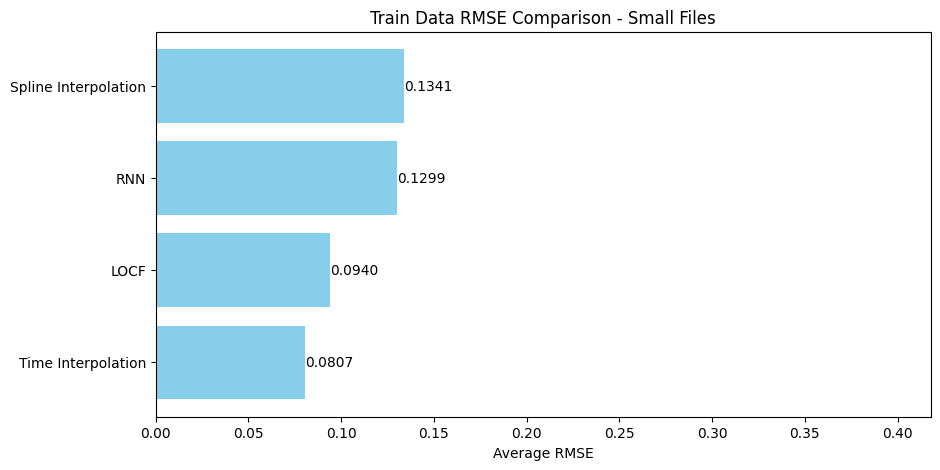

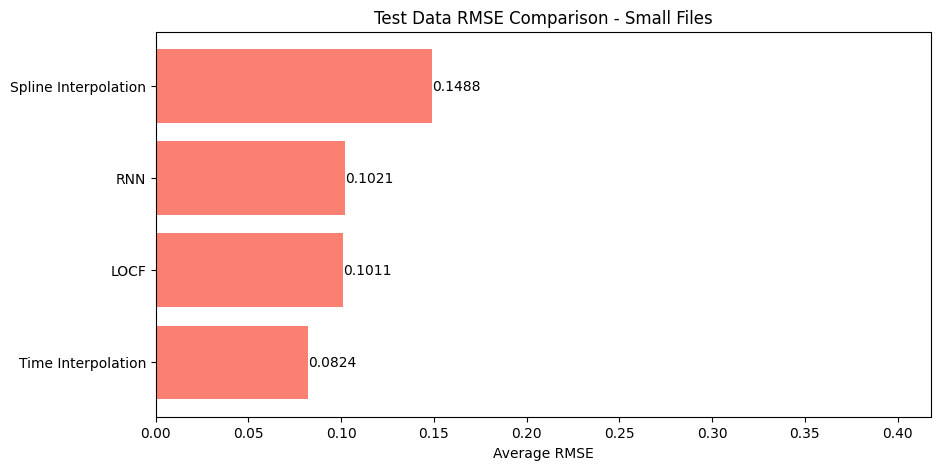

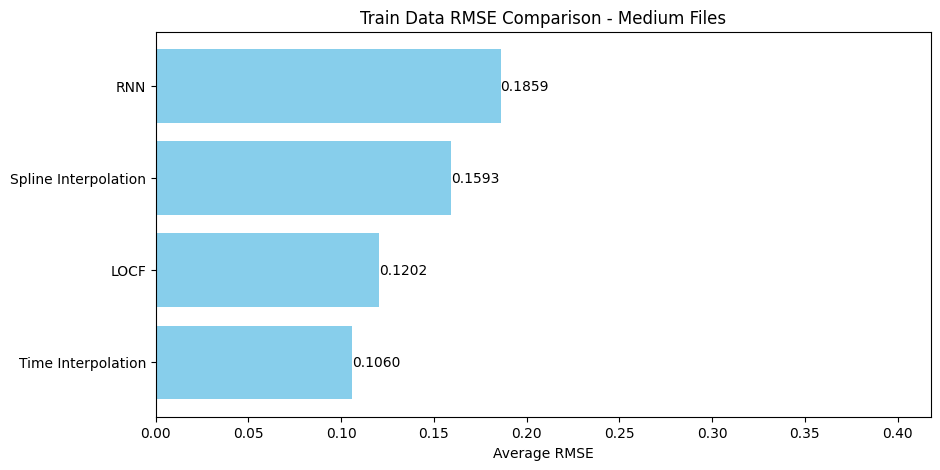

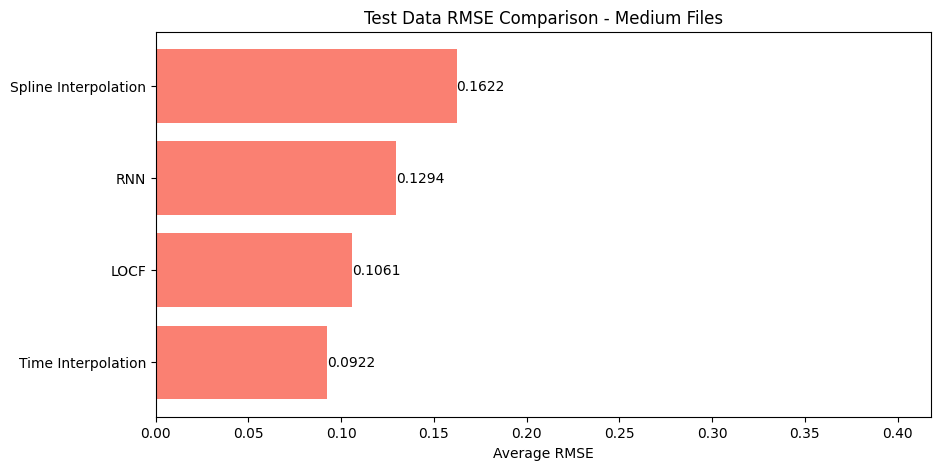

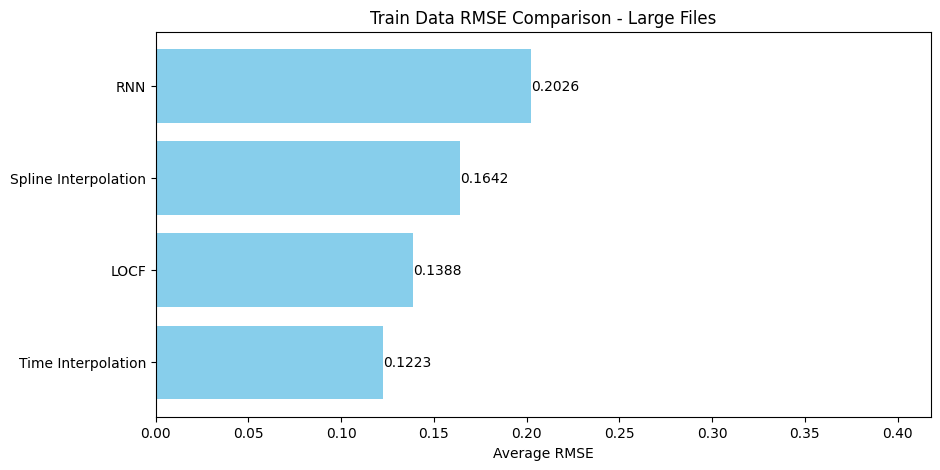

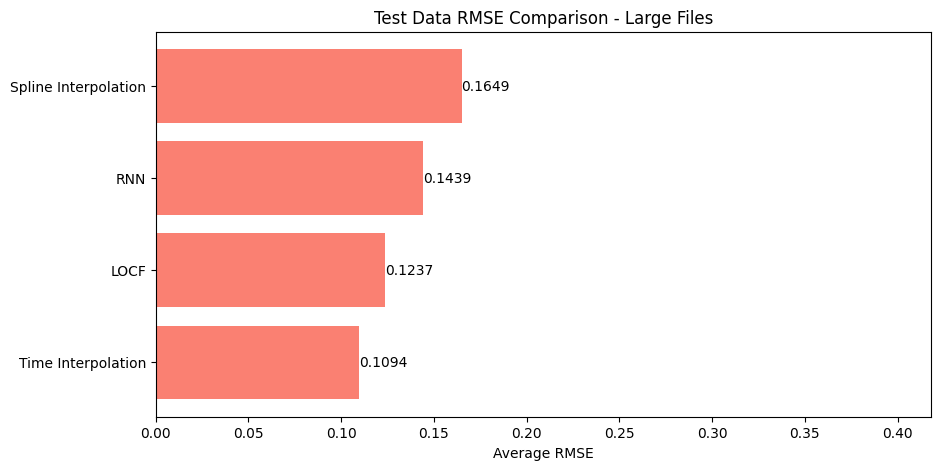

In [8]:
def get_size_category(size):
    """
    Categorizes file size into 'small', 'medium', or 'large' based on predefined thresholds.

    Args:
        size (int): File size in bytes.

    Returns:
        str: Size category ('small', 'medium', or 'large').
    """
    if size < 0.5 * 1024 * 1024:  # Smaller than 0.5MB
        return 'small'
    elif size < 1 * 1024 * 1024:  # Smaller than 1MB
        return 'medium'
    else:  # Larger files up to 25MB
        return 'large'

def plot_imputation_results_separate(results_folder='time_miss_results', data_folder='shares_datasets/'):
    """
    Plots average RMSE values for different imputation methods separately for training and testing data.

    Args:
        results_folder (str, optional): Path to the folder containing imputation results CSV files. Defaults to 'time_miss_results'.
        data_folder (str, optional): Path to the folder containing datasets. Defaults to 'shares_datasets/'.

    Returns:
        None
    """
    result_files = glob.glob(os.path.join(results_folder, '*_imputation_results.csv'))
    
    method_results_train = {'small': {}, 'medium': {}, 'large': {}}
    method_results_test = {'small': {}, 'medium': {}, 'large': {}}
    max_rmse = 0
    
    for result_file in result_files:
        filename = os.path.basename(result_file).replace('_imputation_results.csv', '')
        original_file = os.path.join(data_folder, filename)
        file_size = os.path.getsize(original_file)
        size_category = get_size_category(file_size)
        
        df = pd.read_csv(result_file, index_col=0)
        for method in df.index:
            try:
                train_rmse = float(df.at[method, 'train_rmse']) if pd.notna(df.at[method, 'train_rmse']) else np.nan
                test_rmse = float(df.at[method, 'test_rmse']) if pd.notna(df.at[method, 'test_rmse']) else np.nan
                if np.isnan(train_rmse) or np.isnan(test_rmse):
                    continue
            except (ValueError, KeyError) as e:
                #print(f"Error processing {method} in {filename}: {e}")
                continue

            if method not in method_results_train[size_category]:
                method_results_train[size_category][method] = []
                method_results_test[size_category][method] = []

            method_results_train[size_category][method].append(train_rmse)
            method_results_test[size_category][method].append(test_rmse)
            max_rmse = max(max_rmse, train_rmse, test_rmse)
    
    for size_category in ['small', 'medium', 'large']:
        train_avgs = {method: np.mean(rmses) for method, rmses in method_results_train[size_category].items() if rmses}
        test_avgs = {method: np.mean(rmses) for method, rmses in method_results_test[size_category].items() if rmses}
        
        for data_type, avgs in zip(['Train', 'Test'], [train_avgs, test_avgs]):
            if avgs:
                plt.figure(figsize=(10, 5))
                methods, values = zip(*sorted(avgs.items(), key=lambda x: x[1]))
                bars = plt.barh(methods, values, color='skyblue' if data_type == 'Train' else 'salmon')
                plt.xlabel('Average RMSE')
                plt.title(f'{data_type} Data RMSE Comparison - {size_category.capitalize()} Files')
                plt.xlim(0, max_rmse * 1.1)

                for bar, value in zip(bars, values):
                    plt.text(value, bar.get_y() + bar.get_height() / 2, f"{value:.4f}" if value < 1 else f"{value:.2f}", va='center')
                plt.show()
            else:
                print(f"No {data_type.lower()} data to display for {size_category} size category.")

plot_imputation_results_separate('time_miss_results', 'shares_datasets/')